# PCA


In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
gs3m_data = pd.read_csv("GS3M.csv")
gs6m_data = pd.read_csv("GS6M.csv")
gs1y_data = pd.read_csv("GS1.csv")
gs3y_data = pd.read_csv("GS3.csv")
gs5y_data = pd.read_csv("GS5.csv")
gs10y_data = pd.read_csv("GS10.csv")

# Merge all data into a single dataframe, joining on the `DATE` column
data = (
    gs3m_data.merge(gs6m_data, on="DATE")
    .merge(gs1y_data, on="DATE")
    .merge(gs3y_data, on="DATE")
    .merge(gs5y_data, on="DATE")
    .merge(gs10y_data, on="DATE")
)

Let's say we have 6 features that represent US treasury yields on bills and bonds since 1981. I've downloaded this data from the FRED (Federal Reserve Economic Data) website and saved it.

In [49]:
# data.to_csv("US_Treasury_Yields.csv", index=False)
data = pd.read_csv("US_Treasury_Yields.csv")
data.describe()

,GS3M,GS6M,GS1,GS3,GS5,GS10
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,3.813864,3.990932,4.141612,4.637612,4.964621,5.415340
std,3.185367,3.290824,3.345033,3.389762,3.293458,3.114021
min,0.010000,0.040000,0.050000,0.160000,0.270000,0.620000
25%,0.855000,0.980000,1.150000,1.535000,2.175000,2.880000
50%,3.840000,4.010000,4.170000,4.400000,4.540000,4.720000
75%,5.710000,5.865000,6.020000,6.500000,6.790000,7.255000
max,15.610000,16.360000,16.520000,16.220000,15.930000,15.320000


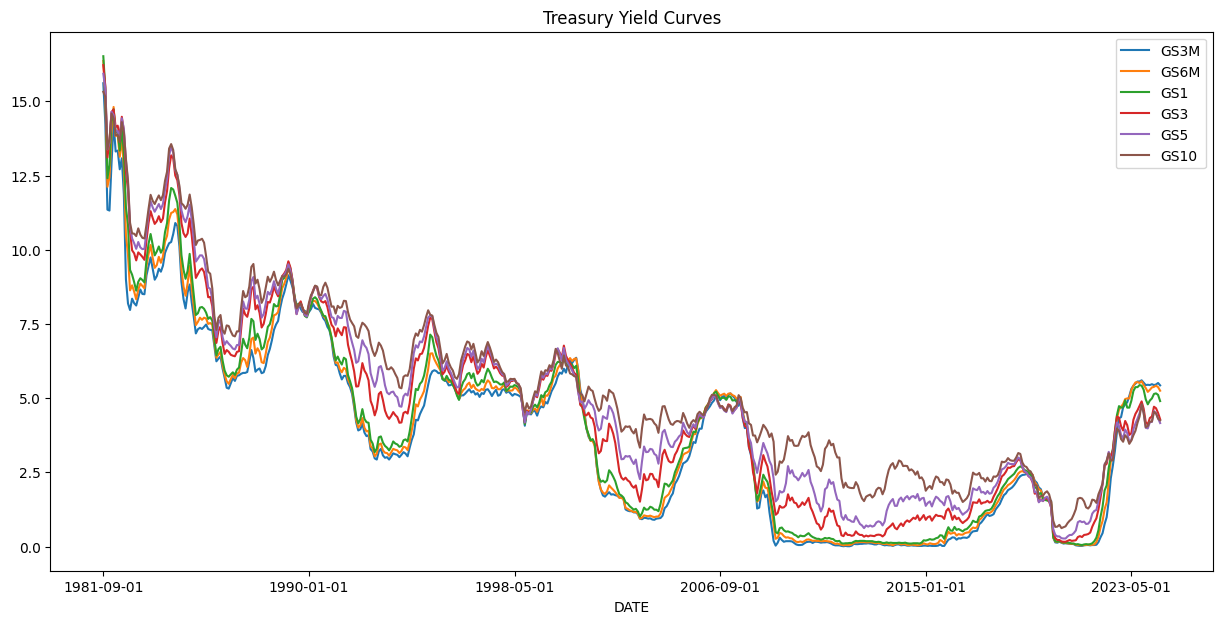

In [32]:
data.plot(x="DATE", y=["GS3M", "GS6M", "GS1", "GS3", "GS5", "GS10"], title="Treasury Yield Curves", figsize=(15, 7));

As expected, we see that there's obviously high correlation between these 6 features. In fact we can take a look at the correlations...

<Axes: >

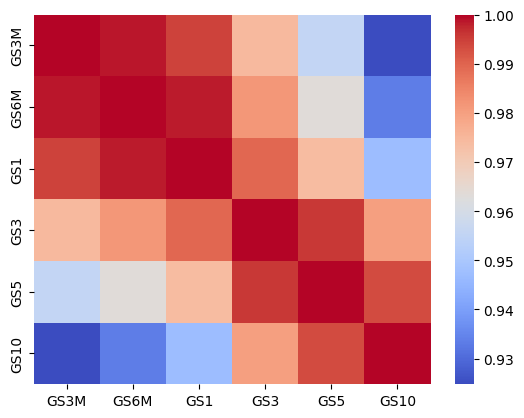

In [53]:
data_numeric = data.drop(columns="DATE")
sns.heatmap(data_numeric.corr(), cmap='coolwarm')

Note that the lowest correlation is still around 93%!! So maybe including all 6 features wouldn't be the best idea. It would be redundant, increase the computational burden and possibly lead to multicollinearity issues. So we wanna see if we can reduce the feature set while preserving much of the variance, and we turn to PCA because we don't wanna just pick manually and arbitrarily.  
Before doing anything else though, we need to scale the features, or else PCA won't work well.

In [57]:
# Standardize the data
data_scaled = (data_numeric - data_numeric.mean()) / data_numeric.std()
data_scaled["DATE"] = data["DATE"]  # Add the `DATE` column back
data_scaled.describe()

,GS3M,GS6M,GS1,GS3,GS5,GS10
count,515.000000,5.150000e+02,5.150000e+02,5.150000e+02,515.000000,515.000000
mean,0.000000,5.518779e-17,-1.103756e-16,5.518779e-17,0.000000,0.000000
std,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000
min,-1.194168,-1.200591e+00,-1.223190e+00,-1.320922e+00,-1.425438,-1.539919
25%,-0.928893,-9.149478e-01,-8.943445e-01,-9.152889e-01,-0.847019,-0.814169
50%,0.008205,5.794282e-03,8.486718e-03,-7.009685e-02,-0.128929,-0.223293
75%,0.595264,5.694829e-01,5.615456e-01,5.494157e-01,0.554244,0.590767
max,3.703226,3.758654e+00,3.700528e+00,3.416874e+00,3.329442,3.180666


Now we can use the PCA class from scikit-learn to transform this data.

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6) # We want to see all 6 components; but for feature selection directly using PCA, we can limit this to the desired number of components
pca.fit(data_scaled.drop(columns="DATE"))
pca.explained_variance_ratio_.tolist()

[0.9781131416016696,
 0.020606126609474605,
 0.001015522605194775,
 0.00021898390702457742,
 3.1292614271084876e-05,
 1.4932662365301447e-05]

You can see how 97% of the variance of the data is already explained by the first component alone! So even if we replace these 6 features with just the first PC we might be good to go! We certainly will be more than okay with the first two, which cover more than 99% of the variance.  

Text(0.5, 0, 'Number of principal component included')

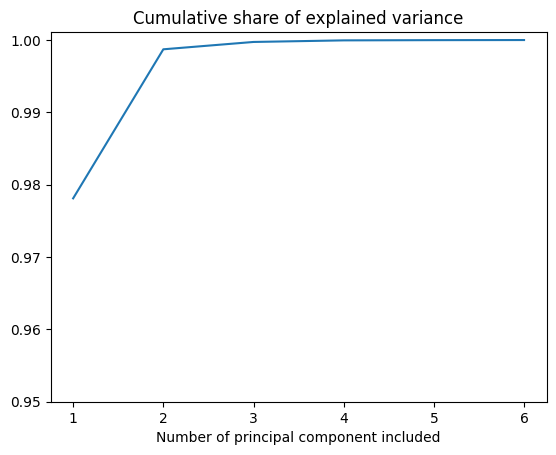

In [73]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(ticks=np.arange(6), labels=np.arange(1, 7))
plt.ylim(ymin=0.95)
plt.title("Cumulative share of explained variance")
plt.xlabel("Number of principal component included")

And let me prove to you BTW that these new components are orthogonal:

<Axes: >

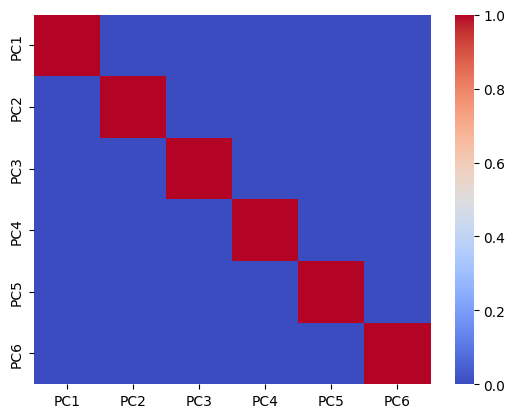

In [64]:
# Show the correlation heatmap of the new components
data_pca = pca.transform(data_scaled.drop(columns="DATE"))
data_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
sns.heatmap(data_pca.corr(), cmap='coolwarm')

Perfectly _uncorrelated_!

Now I said in the lecture that PCA components usually don't really have an intuitively discenible meaning. Well, for treasury yield curves, they kinda do. The first component captures the general trend of the **level** of interest rates, and the second and third components capture second- and third-order dynamics like slope and curvature. We won't get into the quantitative finance details.  
But notably I must point out that the **sign** of the output components (in other words the direction of the transformed system of coordinates) is arbitrary. We could have gotten the vertically flipped version of this chart. Which is absolutely fine for our purposes, which is feeding the data to an ML model. I just wanted to mention this so you won't be surprised if you see rising interest rates when you do this!

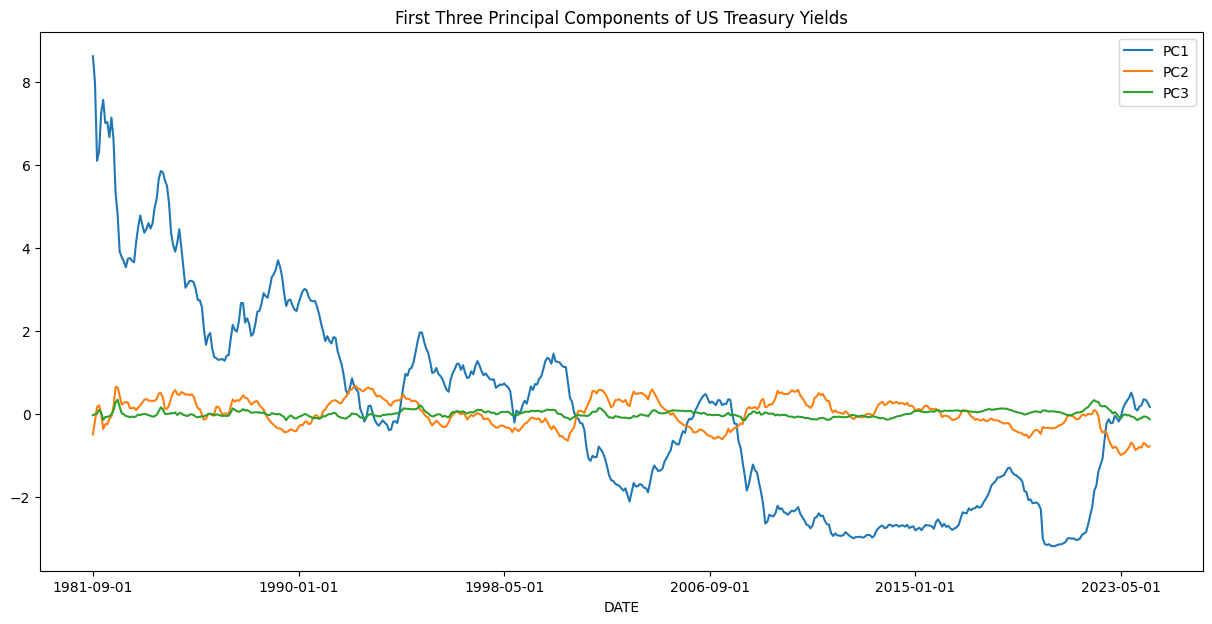

In [77]:
# Plot the first three components
data_pca["DATE"] = data["DATE"]
data_pca.plot(x="DATE", y=["PC1", "PC2", "PC3"], title="First Three Principal Components of US Treasury Yields", figsize=(15, 7));

And one final word: Now that we've transformed these features for training the model, we of course need to apply this same transformation to the features when we test the model or use it for inference. So we want to make this PCA object with its learned components and statistics as part of our pipeline.